In [1]:
"""Examine convolution and Fourier transform"""

'Examine convolution and Fourier transform'

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from common.fft import fft_1d, ifft_1d
from common.utils import step_func_gen
from common.operators import custom_operator_1d
from deblurring.blurring import gaussian

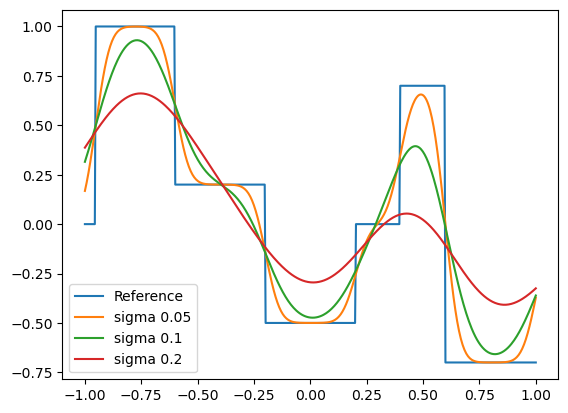

In [3]:
"""Plot step function after convolving with blurring kernel of different standard deviations"""

fig = plt.figure()

N = 500
x, f = step_func_gen(N)
sigmas = [0.05, 0.1, 0.2]

plt.plot(x, f, label="Reference")

for sigma in sigmas:
    kernel = gaussian(x=x, mu=0.0, sigma=sigma)
    A = custom_operator_1d(kernel=kernel, arr_size=N).toarray()
    f_blur = A @ f
    plt.plot(x, f_blur, label=f"sigma {sigma}")

plt.legend()
plt.show()

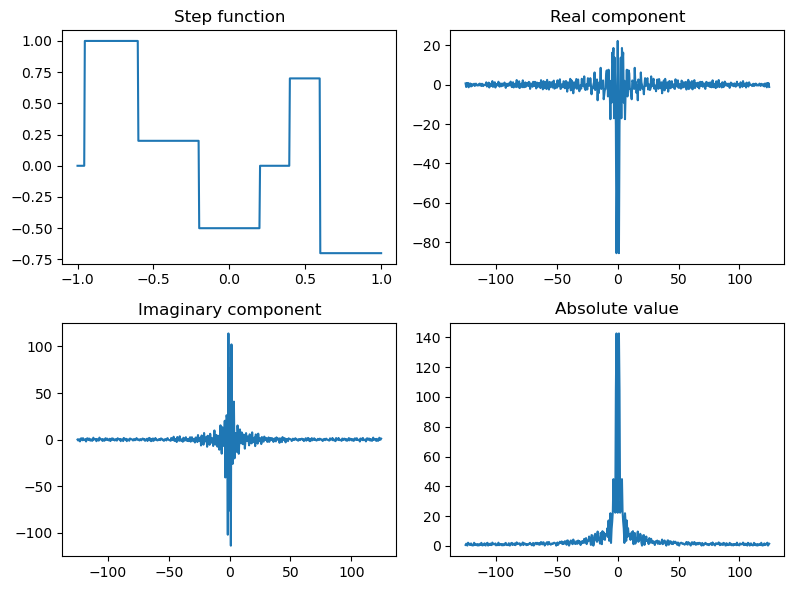

In [4]:
"""Plot FFT of step function"""

freq, F_fft = fft_1d(f, x)
fig = plt.figure(figsize=(8, 6))

plt.subplot(2, 2, 1)
plt.plot(x, f)
plt.title("Step function")
plt.subplot(2, 2, 2)
plt.plot(freq, F_fft.real)
plt.title("Real component")
plt.subplot(2, 2, 3)
plt.plot(freq, F_fft.imag)
plt.title("Imaginary component")
plt.subplot(2, 2, 4)
plt.plot(freq, np.abs(F_fft))
plt.title("Absolute value")

plt.tight_layout()
plt.show()

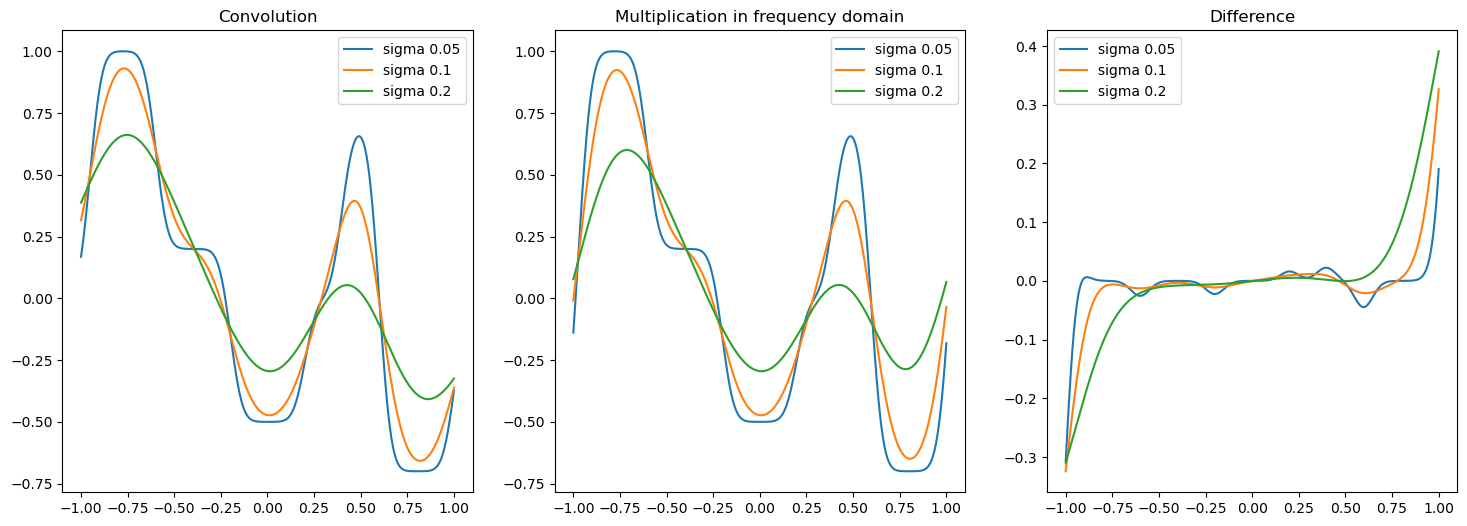

In [5]:
"""Plot comparison of convolution and multiplication in frequency domain"""

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for sigma in sigmas:
    # Perform convolution
    kernel = gaussian(x=x, mu=0.0, sigma=sigma)
    A = custom_operator_1d(kernel=kernel, arr_size=N, conv_mode="same").toarray()
    f_blur_conv = A @ f
    axs[0].plot(x, f_blur_conv, label=f"sigma {sigma}")

    # Get FFT of kernel and filter in frequency domain
    _, kernel_fft = fft_1d(kernel, x)
    freq, F_fft = fft_1d(f, x)
    F_blur = F_fft * kernel_fft
    _, f_blur_fft = ifft_1d(F_blur, freq)

    axs[1].plot(x, f_blur_fft, label=f"sigma {sigma}")
    axs[2].plot(x, f_blur_fft - f_blur_conv, label=f"sigma {sigma}")

axs[0].legend()
axs[0].set_title("Convolution")
axs[1].legend()
axs[1].set_title("Multiplication in frequency domain")
axs[2].legend()
axs[2].set_title("Difference")
plt.show()

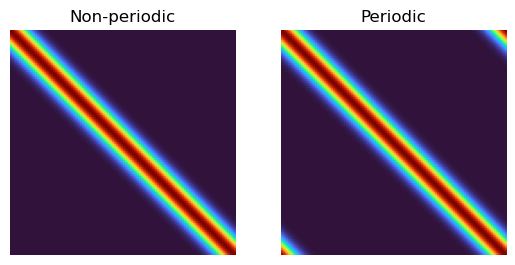

In [6]:
"""Display difference between periodic and non-periodic convolutional matrices"""

A = custom_operator_1d(
    kernel=gaussian(np.linspace(-1, 1, 100), mu=0.0, sigma=0.1),
    arr_size=100, conv_mode="same"
).toarray()
A_periodic = custom_operator_1d(
    kernel=gaussian(np.linspace(-1, 1, 100), mu=0.0, sigma=0.1),
    arr_size=100, conv_mode="periodic"
).toarray()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(A, cmap="turbo")
axs[0].axis("off")
axs[0].set_title("Non-periodic")
axs[1].imshow(A_periodic, cmap="turbo")
axs[1].axis("off")
axs[1].set_title("Periodic")
plt.show()

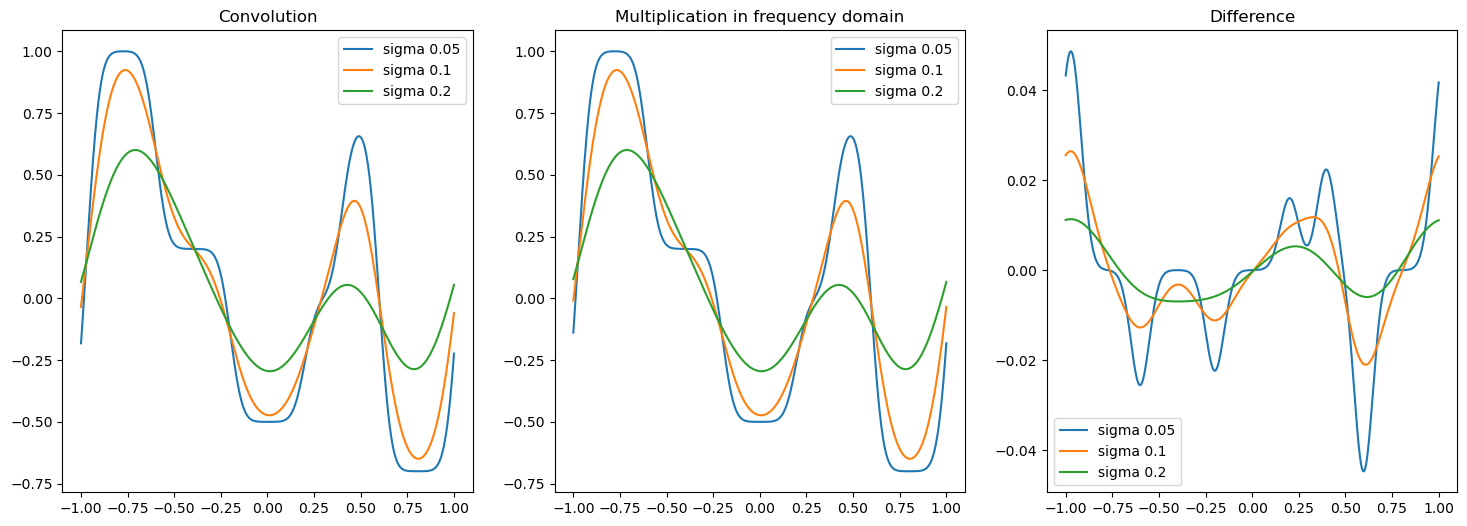

In [7]:
"""Plot comparison of convolution and multiplication in frequency domain
for periodic operator."""

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for sigma in sigmas:
    # Perform convolution
    kernel = gaussian(x=x, mu=0.0, sigma=sigma)
    A = custom_operator_1d(kernel=kernel, arr_size=N, conv_mode="periodic").toarray()
    f_blur_conv = A @ f
    axs[0].plot(x, f_blur_conv, label=f"sigma {sigma}")

    # Get FFT of kernel and filter in frequency domain
    _, kernel_fft = fft_1d(kernel, x)
    freq, F_fft = fft_1d(f, x)
    F_blur = F_fft * kernel_fft
    _, f_blur_fft = ifft_1d(F_blur, freq)
    
    axs[1].plot(x, f_blur_fft, label=f"sigma {sigma}")
    axs[2].plot(x, f_blur_fft - f_blur_conv, label=f"sigma {sigma}")

axs[0].legend()
axs[0].set_title("Convolution")
axs[1].legend()
axs[1].set_title("Multiplication in frequency domain")
axs[2].legend()
axs[2].set_title("Difference")
plt.show()

In [8]:
"""Comparison of blurring kernel singular value standard deviations and
standard deviations of blurring kernel in frequency domain."""

num_samples = 100
sing_vals = np.zeros((len(sigmas), num_samples))
x = np.linspace(-1, 1, num_samples)

for idx, sigma in enumerate(sigmas):
    # Get singular values from SVD
    kernel = gaussian(x=x, mu=0.0, sigma=sigma)
    A = custom_operator_1d(kernel=kernel, arr_size=num_samples, conv_mode="periodic").toarray()
    _, W, _ = np.linalg.svd(A)
    sing_vals[idx, :] = W
    sing_vals_reflect = np.zeros((len(sigmas), 2 * num_samples - 1))

    # Mirror SVD spectrum to mimic Gaussian
    sing_vals_reflect[idx, num_samples:] = sing_vals[idx, 1:]
    sing_vals_reflect[idx, 0:num_samples] = sing_vals[idx, ::-1]
    sing_vals_reflect[idx, :] /= sing_vals_reflect[idx, :].sum()

    # Get freq values for mirrored singular values
    x_min, x_max = -1, 1
    delta_k = 1 / (x_max - x_min)  # Freq step size
    k_min = -num_samples / 2 * delta_k
    k_max = num_samples / 2 * delta_k
    sing_k_vals = np.linspace(k_min, k_max, num_samples * 2 - 1)  # Freq values

    # Get kernel in frequency domain and freq values from FFT
    kernel = gaussian(x=x, mu=0.0, sigma=sigma)
    fft_k_vals, kernel_fft = fft_1d(kernel, x)

    # Compare standard deviations
    std_dev_sing = np.sqrt(np.average(np.square(sing_k_vals), weights=sing_vals_reflect[idx, :]))
    std_dev_fft = np.abs(np.sqrt(np.average(np.square(fft_k_vals), weights=kernel_fft)))

    print(f"FFT kernel std {std_dev_fft}: singular value std {std_dev_sing}")
    

FFT kernel std 3.1489572479986254: singular value std 3.2003605841780334
FFT kernel std 1.59940332574561: singular value std 1.5795958956167042
FFT kernel std 0.8027870224759985: singular value std 0.7742534735012828
